# Cloud Constable Content-Based Threat Detection
______
### Stephen Camera-Murray, Himani Garg, Vijay Thangella
## Wikipedia Personal Attacks corpus
(https://figshare.com/articles/Wikipedia_Detox_Data/4054689)

115,864 verbatims out of which 13,590 are labelled aggressive and 102,274 are not.

Aggressive Speech                                      |  Normal Speech
:-----------------------------------------------------:|:------------------------------------------------------:
<img src="thumbsdown.png" alt="Aggressive" style="width: 200px;"/> | <img src="thumbsup.png" alt="Normal" style="width: 200px;"/>

### Step 2 - Feature Extraction and Analysis
____

#### Import required libraries

In [42]:
#import libraries
import numpy as np
import pandas as pd
import nltk
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import cross_val_score
import heapq
from sklearn.svm import SVC
import sklearn.grid_search as gs
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import itertools


#### Load Clean Dataframe

In [3]:
# load the labels file
verbatimsDF = pd.read_csv ('data/cleansedVerbatims.tab.gz', compression='gzip', sep='\t')
verbatimsDF.head()

,content,aggressive
0,this is not creative those are the dictionary...,0.0
1,the term standard model is itself less npov t...,0.0
2,true or false the situation as of march was s...,0.0
3,next maybe you could work on being less conde...,0.0
4,this page will need disambiguation,0.0


#### Apply Stemming
Let's go back to this one later.

In [4]:
stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
     # now stem the tokens
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens



#### Feature Extraction
We start with word vectorization of each email's text with a simple bag of words approach. We should test whether or not n-gram frequencies or character-based analysis might yield improvements.

In [5]:
# set up the vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3000, tokenizer = tokenize_and_stem) # remove stopwords and go with mostly defaults for now
verbatimsVec = vectorizer.fit_transform(verbatimsDF['content'])

print ( 'The vectorized counts have', '{:,}'.format ( verbatimsVec.shape[0] ), 'rows and', '{:,}'.format ( verbatimsVec.shape[1] ), 'features.' )

RuntimeError: maximum recursion depth exceeded in cmp

Yikes, 139K features might be a bit much to keep, unless we do PCR to trim it down or keep them all for deep learning later. Let's have a look at some of these features to see that they're even worth keeping.

In [5]:
vectorizer.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany',
 'aaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaaaaah',
 'aaaaaaaaaahhhhhhhhhhhhhh',
 'aaaaaaaaadm',
 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaaari',
 'aaaaaaaayui',
 'aaaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreeee',
 'aaaawwww',
 'aaabbccz',
 'aaaboyz',
 'aaages',
 'aaagh',
 'aaah',
 'aaahh',
 'aaahhh',
 'aaahs',
 'aaai',
 'aaand',
 'aaargh',
 'aaarrrgggh',
 'aaas',
 'aab',
 'aabb',
 'aabi',
 'aac',
 'aacademic',
 'aacenc',
 'aachen',
 'aachi',
 'aachttps',
 'aad',
 'aademia',
 'aadhe',
 'aadmi',
 'aadministrators',
 'aadt',
 'aadu',
 'aaets',
 'aaf',
 'aaffect',
 'aafia',
 'aaflight',
 'aafuss',
 'aag',
 'aage',
 'aagin',
 'aah',
 'aahank',
 'aahh',
 'aahoa',
 'aai',
 'aaib',
 'aake',
 'aaker',
 '

Hmm, I'm not sure much of this will help. Let's bring that down to something more reasonable like the top 3K features.

In [4]:
# set up the vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=3000) # keep only the top 3K features
verbatimsVec = vectorizer.fit_transform(verbatimsDF['content'])

print ( 'The vectorized counts have', '{:,}'.format ( verbatimsVec.shape[0] ), 'rows and', '{:,}'.format ( verbatimsVec.shape[1] ), 'features.' )

('The vectorized counts have', '115,864', 'rows and', '3,000', 'features.')


Let's try that again and we see that our features now make more sense.

In [4]:
vectorizer.get_feature_names()

[u'ability',
 u'able',
 u'absolute',
 u'absolutely',
 u'absurd',
 u'abuse',
 u'abusing',
 u'abusive',
 u'academic',
 u'accept',
 u'acceptable',
 u'accepted',
 u'access',
 u'according',
 u'account',
 u'accounts',
 u'accuracy',
 u'accurate',
 u'accurately',
 u'accusation',
 u'accusations',
 u'accuse',
 u'accused',
 u'accusing',
 u'achieve',
 u'acknowledge',
 u'act',
 u'acting',
 u'action',
 u'actions',
 u'active',
 u'activities',
 u'activity',
 u'actor',
 u'acts',
 u'actual',
 u'actually',
 u'ad',
 u'add',
 u'added',
 u'adding',
 u'addition',
 u'additional',
 u'additionally',
 u'additions',
 u'address',
 u'addressed',
 u'addresses',
 u'addressing',
 u'adds',
 u'admin',
 u'administration',
 u'administrative',
 u'administrator',
 u'administrators',
 u'admins',
 u'admit',
 u'admitted',
 u'adopted',
 u'advance',
 u'advertising',
 u'advice',
 u'advise',
 u'afd',
 u'afghanistan',
 u'afraid',
 u'africa',
 u'african',
 u'age',
 u'agenda',
 u'agf',
 u'aggressive',
 u'ago',
 u'agree',
 u'agreed',


In [8]:
tf_transformer = TfidfTransformer(use_idf=True)
X_tfidf = tf_transformer.fit_transform(verbatimsVec).toarray()
X_tfidf.shape

(115864L, 3000L)

In [4]:
# No. of training points
def sk_split(x,y):
    n = len(x)
    n_train = int(n * 2.0 / 3.0)

# Random 2/3rd train, remaining test
    perm = np.random.permutation(n)
    y_train = y[perm[0:n_train]]
    x_train = x[perm[0:n_train]]
    y_test = y[perm[n_train:]]
    x_test = x[perm[n_train:]]
    return x_train , x_test ,y_train ,y_test

In [9]:
# No. of training points
def sk_split(x,y):
    n = len(x)
    n_train = int(n * 2.0 / 3.0)

# Random 2/3rd train, remaining test
    perm = np.random.permutation(n)
    y_train = y[perm[0:n_train]]
    x_train = x[perm[0:n_train]]
    y_test = y[perm[n_train:]]
    x_test = x[perm[n_train:]]
    return x_train , x_test ,y_train ,y_test

In [10]:
# Spilt the data 
x_train , x_test , y_train , y_test  =  sk_split(X_tfidf,verbatimsDF["aggressive"].values)

In [32]:
SGD = SGDClassifier(loss='hinge', penalty='l1', alpha=.0001, n_iter=5, random_state=42,class_weight="balanced")
SGD.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [33]:
# score on test and train
score_train = SGD.score(x_train,y_train)
Score_test = SGD.score(x_test,y_test)
Score_test_0 =SGD.score(x_test[y_test==0], y_test[y_test==0])
Score_test_1 = SGD.score(x_test[y_test==1], y_test[y_test==1])


# Print the Scores
print "Train Score:",score_train
print "Test Score:",Score_test
print "Test Score for Class 0:", Score_test_0
print "Test Score for Class 1:", Score_test_1


Train Score: 0.917078791331
Test Score: 0.91370203511
Test Score for Class 0: 0.930717495374
Test Score for Class 1: 0.787010715067


In [36]:
# predict train and test 
pred_train = SGD.predict ( x_train )
pred_test  = SGD.predict ( x_test )

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round ( cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 4 )
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted labeel')

In [37]:
confusion_matrix(y_test, pred_test)

array([[31690,  2359],
       [  974,  3599]])

Normalized confusion matrix
[[ 0.9307  0.0693]
 [ 0.213   0.787 ]]


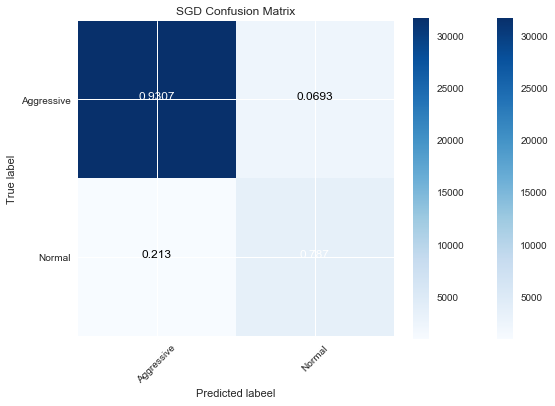

In [43]:
SGDCM = confusion_matrix (  y_test, pred_test )

# Plot normalized confusion matrix
plot_confusion_matrix(SGDCM , classes=['Aggressive','Normal'], normalize=True,
                      title='SGD Confusion Matrix')

plt.show()